In [1]:
!pwd

%matplotlib inline
%reload_ext autoreload
%autoreload 2

import sys
sys.executable

/c/Users/shingo/jupyter_notebook/stock_work/03.stock_repo/sarimax_analysis


'C:\\Users\\shingo\\Anaconda3\\envs\\stock\\python.exe'

### モジュールimport

In [2]:
import sarimax_analysis as s_ana

### データロード

statsmodels version: 0.11.1


,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
1949-11-01    104.0
1949-12-01    118.0
1950-01-01    115.0
1950-02-01    126.0
1950-03-01    141.0
1950-04-01    135.0
1950-05-01    125.0
1950-06-01    149.0
1950-07-01    170.0
1950-08-01    170.0
1950-09-01    158.0
1950-10-01    133.0
1950-11-01    114.0
1950-12-01    140.0
1951-01-01    145.0
1951-02-01    150.0
1951-03-01    178.0
1951-04-01    163.0
1951-05-01    172.0
1951-06-01    178.0
              ...  
1958-07-01    491.0
1958-08-01    505.0
1958-09-01    404.0
1958-10-01    359.0
1958-11-01    310.0
1958-12-01    337.0
1959-01-01    360.0
1959-02-01    342.0
1959-03-01    406.0
1959-04-01    396.0
1959-05-01    420.0
1959-06-01    472.0
1959-07-01    548.0
1959-08-01    559.0
1959-09-01    463.0
1959-10-01    407.0
1959-11-01    362.0
1959-12-01    405.0
1960-01-01    

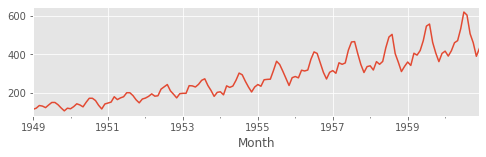

In [3]:
# ライブラリーインポート、グラフ描画準備
import os
import joblib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('ggplot')
# plt.xkcd()  # 漫画っぽいグラフにするおまじない

# statsmodels のバージョン確認
print('statsmodels version:', sm.__version__) # SARIMAX利用に0.8.0以上が必要

# csvは https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv からダウンロードした
df = pd.read_csv('AirPassengers.csv',
                 index_col=0, parse_dates=[0], dtype='float')
display(df.head())

# pandasのSeriesに乗客数データを格納
ts = df['#Passengers']
display(ts)

# 乗客数データをグラフで可視化(pandas.plot)
ts.plot(figsize=(8, 2))

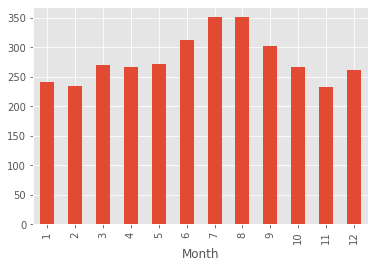

In [4]:
# 乗客数の平均が多い月確認
month_mean = ts.groupby(ts.index.month).mean()
month_mean.plot.bar()

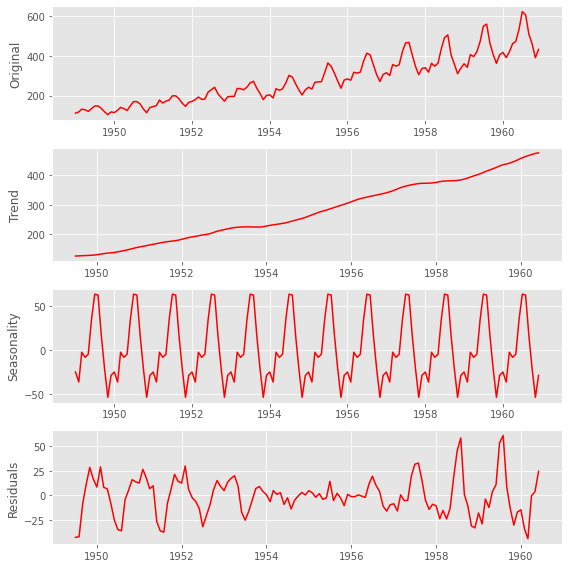

In [5]:
# オリジナル ->トレンド成分、季節成分、残差成分に分解してプロット
res = s_ana.plot_seasonal_decompose(ts)

### 定常性確認+周期性確認

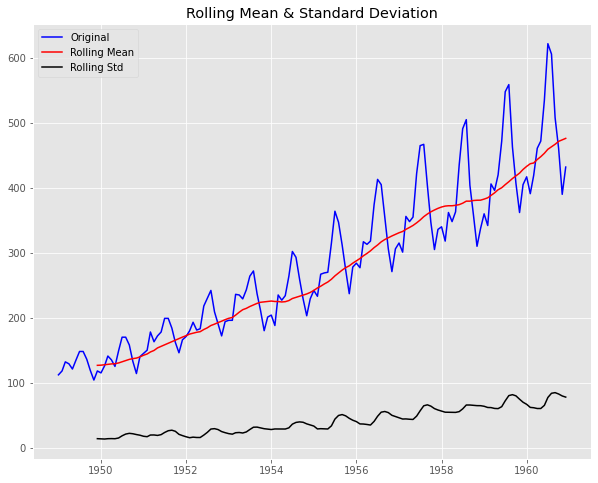

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


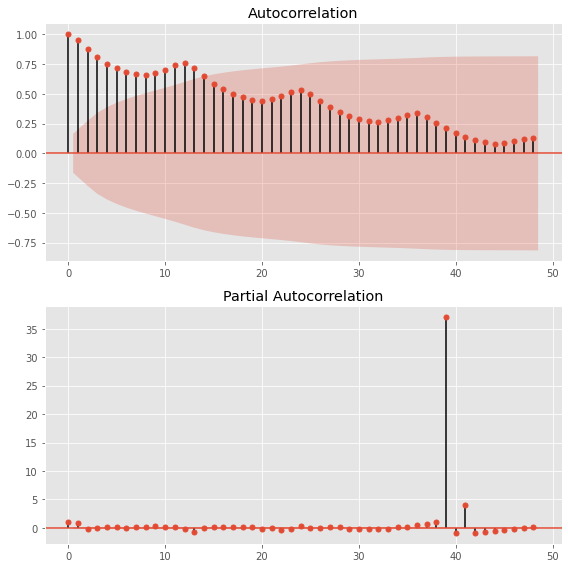

In [6]:
# p値高い(0.991880)ので帰無仮説棄却できない=データは非定常過と言える
s_ana.plot_stationarity(ts, window_size=12)

# 自己相関と偏自己相関のグラフplotして、過去の値が現在のデータにどれくらい影響しているか確認する
# タイムラグ（Lag）がゼロのときの自己相関は 1.00
# 時系列のグラフからもわかるように、ある年tの値が大きければ、その12か月後の値も大きい。
# そのために、連続する 12か月後の自己相関が高いことがわかる。
# しかし、タイムラグを長くすると、上昇から下落あるいは下落から上昇の区間のデータの影響が加わり、
# 自己相関が徐々に低くなる
s_ana.plot_acf_pacf(ts)

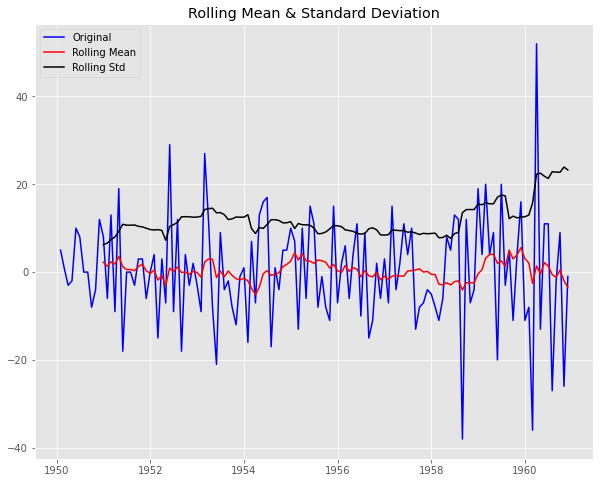

Results of Dickey-Fuller Test:
Test Statistic                -1.559562e+01
p-value                        1.856512e-28
#Lags Used                     0.000000e+00
Number of Observations Used    1.300000e+02
Critical Value (1%)           -3.481682e+00
Critical Value (5%)           -2.884042e+00
Critical Value (10%)          -2.578770e+00
dtype: float64


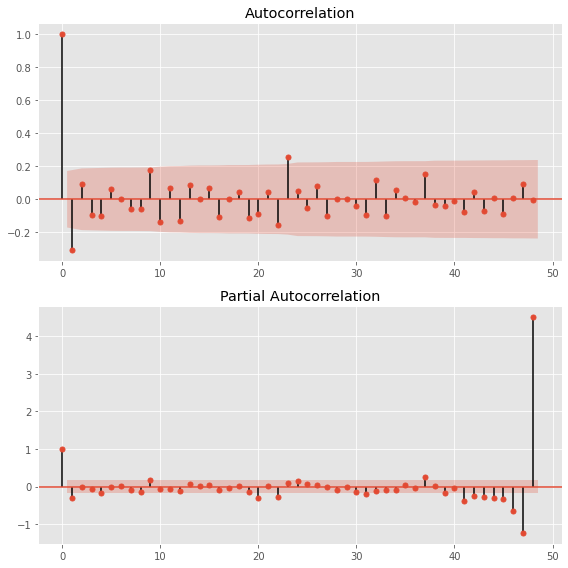

In [7]:
# 一次の差分と、季節性を取り除いた場合
# p値(1.856512e-28)<0.05(5%未満)なので、帰無仮説棄却＝データ定常
diff = ts - ts.shift(1)
diff = diff.dropna()
diff = diff - diff.shift(12)
diff = diff.dropna()
s_ana.plot_stationarity(diff, window_size=12)

# 自己相関と偏自己相関のグラフplotして、過去の値が現在のデータにどれくらい影響しているか確認する
# 一次の差分と、季節性を取り除いた場合が一番p値低いし、自己相関のplotから周期性取り除かれていることがわかる
s_ana.plot_acf_pacf(diff)

### モデル作成+予測

In [8]:
args = {'input_csv': 'AirPassengers.csv', 
        'split_n_train_test': 120,
        'output_dir': 'output',
        'n_trials': 50,
        'fix_param_s': 12
       }
        
# train/test set にデータ分割
# 周期性に合わせて分けないとうまくいかないことがあった
ts_train = ts[:args['split_n_train_test']]
ts_test = ts[args['split_n_train_test']:]

In [9]:
# SARIMAXパラメータチューニング
study = s_ana.run_optuna(ts_train, 
                         args['output_dir'], 
                         n_trials=args['n_trials'], 
                         fix_s=args['fix_param_s'])

[I 2020-05-28 21:51:18,776] Finished trial#0 with value: 622.1094576541531 with parameters: {'s': 12, 'trend': 'ct', 'p': 3, 'd': 2, 'q': 2, 'P': 1, 'D': 1, 'Q': 2, 'enforce_stationarity': False, 'enforce_invertibility': False}. Best is trial#0 with value: 622.1094576541531.
[I 2020-05-28 21:51:22,696] Finished trial#1 with value: 600.3728486070481 with parameters: {'s': 12, 'trend': None, 'p': 3, 'd': 3, 'q': 4, 'P': 1, 'D': 1, 'Q': 2, 'enforce_stationarity': False, 'enforce_invertibility': False}. Best is trial#1 with value: 600.3728486070481.
[I 2020-05-28 21:51:24,526] Finished trial#2 with value: 829.4034274801257 with parameters: {'s': 12, 'trend': 'ct', 'p': 1, 'd': 4, 'q': 2, 'P': 1, 'D': 0, 'Q': 2, 'enforce_stationarity': False, 'enforce_invertibility': False}. Best is trial#1 with value: 600.3728486070481.
[I 2020-05-28 21:51:25,675] Finished trial#3 with value: 706.2955362215415 with parameters: {'s': 12, 'trend': 't', 'p': 4, 'd': 0, 'q': 3, 'P': 0, 'D': 1, 'Q': 1, 'enforce

試行回数: 50
目的関数を最小化するbestパラメータ: {'s': 12, 'trend': 'ct', 'p': 4, 'd': 2, 'q': 1, 'P': 2, 'D': 2, 'Q': 1, 'enforce_stationarity': False, 'enforce_invertibility': False}
目的関数の最小値: 504.32882423966333


model.summary():                                       SARIMAX Results                                      
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(4, 2, 1)x(2, 2, 1, 12)   Log Likelihood                -241.164
Date:                            Thu, 28 May 2020   AIC                            504.329
Time:                                    21:53:39   BIC                            528.415
Sample:                                01-01-1949   HQIC                           513.846
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1799      0.703      0.256      0.798      -1.199       1.559
drift         -0.

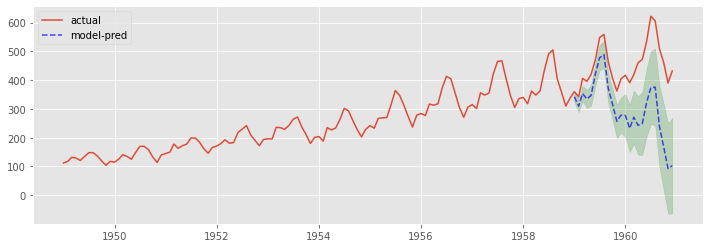

In [10]:
# bestパラメでモデル作成
model = sm.tsa.statespace.SARIMAX(ts_train,
                                  trend=study.best_params['trend'],
                                  order=(study.best_params['p'], 
                                         study.best_params['d'], 
                                         study.best_params['q']),
                                  seasonal_order=(study.best_params['P'], 
                                                  study.best_params['D'], 
                                                  study.best_params['Q'], 
                                                  study.best_params['s']),
                                  enforce_stationarity=study.best_params['enforce_stationarity'],
                                  enforce_invertibility=study.best_params['enforce_invertibility']
                                  ).fit()
print('model.summary(): ', model.summary())

# モデル保存
training_info = {'training_data': args['input_csv'], 'model_type': 'SARIMAX', 'hyper_pram': study.best_params}
save_data, filepath = s_ana.save_model_info(model,
                                      training_info,
                                      preprocess_pipeline=None,
                                      output_path=os.path.join(args['output_dir'], 'SARIMAX_best.joblib'))
load_data = joblib.load(filepath)

# 予測
ts_pred = s_ana.predict_load_model(filepath,
                             ts_test.index[0].strftime('%Y-%m-%d'),
                             ts_test.index[-1].strftime('%Y-%m-%d'),
                             ts=ts,
                             out_png=os.path.join(args['output_dir'], 'ts_pred.png'))

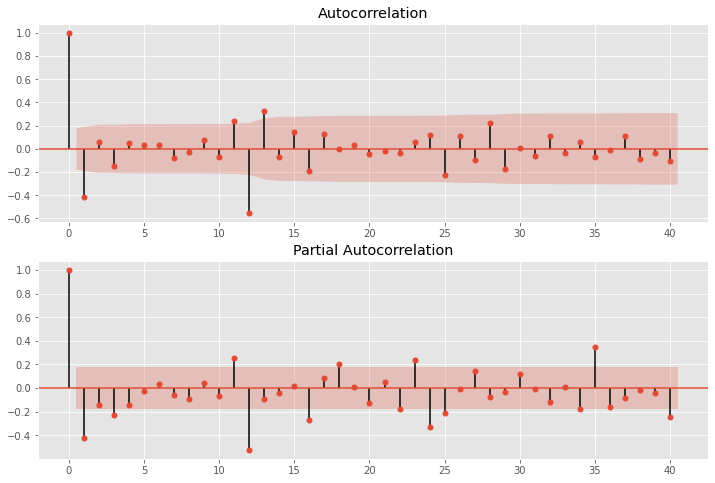

In [11]:
# 残差のチェック
residSARIMA = model.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(residSARIMA, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(residSARIMA, lags=40, ax=ax2)